In [1]:
import os
import re
from preprocess import preprocess
from feature_extraction import extract_feature
from training import train


img_dir = "augmentation"
data_file = "names.txt"

with open(data_file, "r") as data:
    datas = data.readlines()

orig_labels = [data.rstrip('\n').split()[1] for data in datas]

img_paths = []
img_labels = []

files = os.listdir(img_dir)
for file in files:
    image_num = int(re.search("(knot)(\d+)(_0_)(\d+)(.ppm)", file).group(2)) - 1
    path = os.path.join(img_dir, file)
    img_paths.append(path)
    img_labels.append(orig_labels[image_num])

Extracting Feature...
[SIFT]1000/9191
[SIFT]2000/9191
[SIFT]3000/9191
[SIFT]4000/9191
[SIFT]5000/9191
[SIFT]6000/9191
[SIFT]7000/9191
[SIFT]8000/9191
[SIFT]9000/9191
Starting k-means clustering...
k-means clustering done...


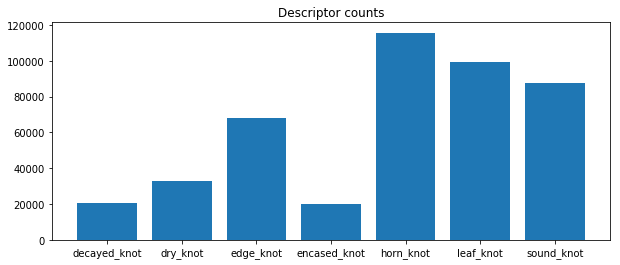

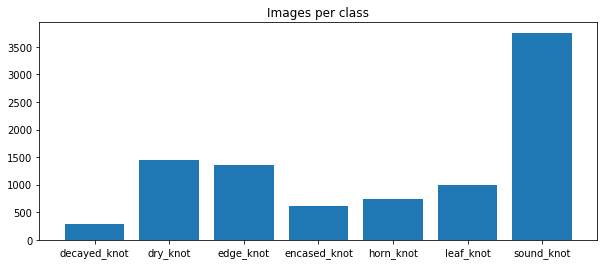

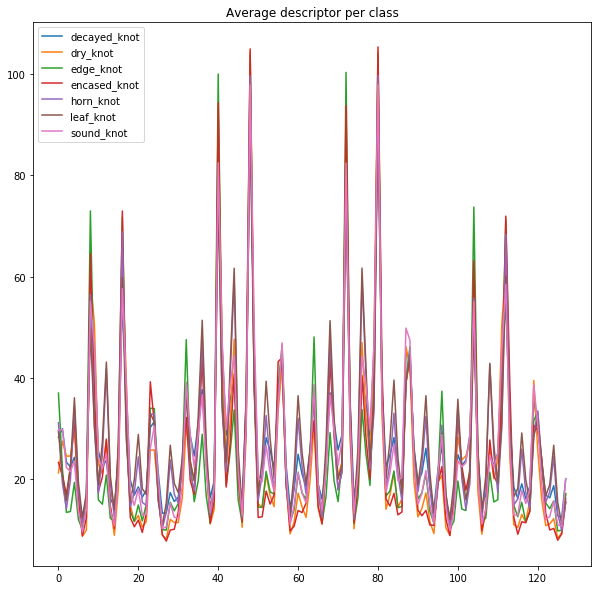

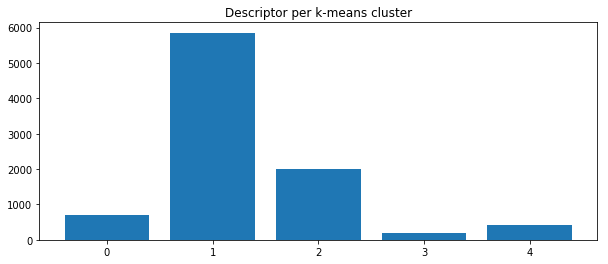

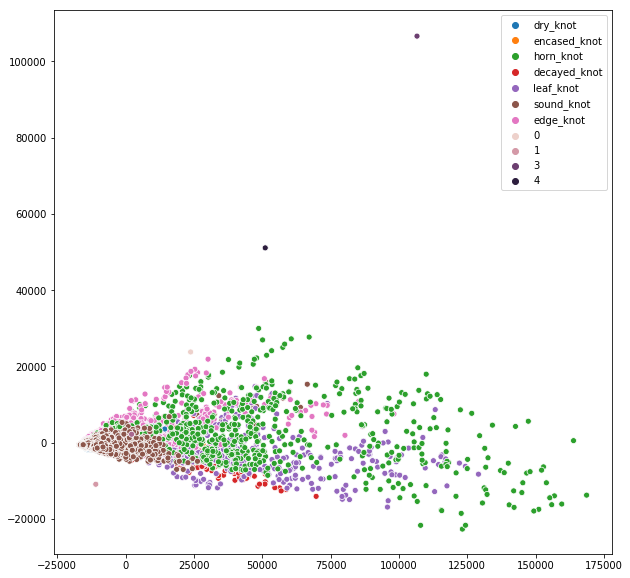

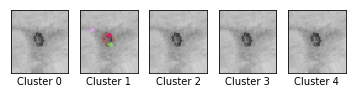

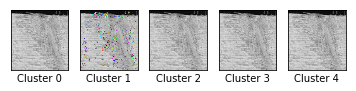

Feature Extracting Done...


In [2]:
print("Extracting Feature...")
extract_feature(img_paths, img_labels)
print("Feature Extracting Done...")

In [3]:
print("Starting Training...")
train(datas, "data")
print("Training Done...")

Starting Training...

ITERATION 1, K: 1
[TRAIN SET RESULT]
	7352/7352(100.0000%)
[TEST SET RESULT]
	1649/1839(89.6683%)

ITERATION 2, K: 3
[TRAIN SET RESULT]
	6996/7352(95.1578%)
[TEST SET RESULT]
	1627/1839(88.4720%)

ITERATION 3, K: 5
[TRAIN SET RESULT]
	6806/7352(92.5734%)
[TEST SET RESULT]
	1609/1839(87.4932%)

ITERATION 4, K: 7
[TRAIN SET RESULT]
	6684/7352(90.9140%)
[TEST SET RESULT]
	1589/1839(86.4057%)

ITERATION 5, K: 9
[TRAIN SET RESULT]
	6591/7352(89.6491%)
[TEST SET RESULT]
	1549/1839(84.2306%)

ITERATION 6, K: 11
[TRAIN SET RESULT]
	6478/7352(88.1121%)
[TEST SET RESULT]
	1531/1839(83.2518%)
Training Done...
